In [1]:
import os
from numpy import genfromtxt
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
from scipy.signal import resample

from data_organizer_Kfall import DataOrganizer
# import torch
#from torch import nn
#from torch.utils.data import DataLoader
#from torch.utils.data import TensorDataset, DataLoader
#from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
# from utils import train, test
import tensorflow as tf
import keras
from keras import models, layers
# from keras.models import Sequential
# from keras.layers import Conv1D, BatchNormalization, ReLU, Softmax, MaxPooling1D, LSTM, Dropout, Dense
from keras.utils import to_categorical
import tensorflow_model_optimization as tfmot


2023-12-07 19:26:56.287047: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-07 19:26:56.287147: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-07 19:26:56.291098: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-07 19:26:56.315376: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-07 19:26:57.243583: W tensorflow/compiler/tf2

# Data Loader

In [2]:
# mac
#sensor_data_folder = '/Users/liuxinqing/Documents/Kfall/sensor_data'  # Update with the path to sensor data
#label_data_folder = '/Users/liuxinqing/Documents/Kfall/label_data'  
# windows 
# sensor_data_folder = 'G:\MLonMCU\Kfall_dataset\sensor_data'  # Update with the path to sensor data
# label_data_folder = 'G:\MLonMCU\Kfall_dataset\label_data' 
# linux
sensor_data_folder = '/home/liyinrong/Projects/MLonMCU/Final/Fall_Detection/datasets/KFall/sensor_data'  # Update with the path to sensor data
label_data_folder = '/home/liyinrong/Projects/MLonMCU/Final/Fall_Detection/datasets/KFall/label_data'  

#window_size = 256
# Kfall: window_size = 50
window_size = 50
threshold = 0.4
num_window_fall_data = 50
num_window_not_fall_data = 5

data, label = DataOrganizer(sensor_data_folder, 
                            label_data_folder, 
                            window_size, 
                            threshold, 
                            num_window_fall_data, 
                            num_window_not_fall_data)

Processing 1/32 folder...
Processing 2/32 folder...
Processing 3/32 folder...
Processing 4/32 folder...
Processing 5/32 folder...
Processing 6/32 folder...
Processing 7/32 folder...
Processing 8/32 folder...
Processing 9/32 folder...
Processing 10/32 folder...
Processing 11/32 folder...
Processing 12/32 folder...
Processing 13/32 folder...
Processing 14/32 folder...
Processing 15/32 folder...
Processing 16/32 folder...
Processing 17/32 folder...
Processing 18/32 folder...
Processing 19/32 folder...
Processing 20/32 folder...
Processing 21/32 folder...
Processing 22/32 folder...
Processing 23/32 folder...
Processing 24/32 folder...
Processing 25/32 folder...
Processing 26/32 folder...
Processing 27/32 folder...
Processing 28/32 folder...
Processing 29/32 folder...
Processing 30/32 folder...
Processing 31/32 folder...
Processing 32/32 folder...


In [3]:
in_channels = data.shape[2]
print('in_channels: ', in_channels)
# the input data should have the shape (batch_size, in_channels, sequence_length)
#data = data.reshape(data.shape[0], in_channels, -1)
print('data.shape: ', data.shape)

in_channels:  9
data.shape:  (25582, 50, 9)


In [4]:
label = label.astype(np.int64)
# one-hot encoding
#label = to_categorical(label, num_classes=2)
# transpose the data to (batch_size, sequence_length, in_channels)
#data = np.transpose(data, (0, 2, 1))
data = data.reshape(data.shape[0], 1, 50, 9)
# (y == 0).sum()
B_size = (label == 0).sum()
A_size = (label == 1).sum()
print('B_size: ', B_size)	
print('A_size: ', A_size)
# transpose the data to (batch_size, in_channels, sequence_length)
#data = np.transpose(data, (0, 2, 1))
print('data.shape: ', data[0][0])
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=42)

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#print(np.unique(y_train)) # [0 1]
y_train = y_train.astype(np.int64)
y_test = y_test.astype(np.int64)


# select the test data that is not zero
X_test_true = X_test[y_test != 0]
y_test_true = y_test[y_test != 0]
# length of the test data
test_len = X_test_true.shape[0]
X_test_false = X_test[y_test == 0]
y_test_false = y_test[y_test == 0]
# X_test.shape:  (17, 50, 9)
# randomly len number of test data that is zero
index = np.random.choice(X_test_false.shape[0], test_len, replace=False)
# X_test.shape:  (17, 50, 9)
# randomly len number of test data that is zero
#index = np.random.choice(X_test_false.shape[0], len, replace=False)


X_test_false = X_test[index]
y_test_false = y_test[index]

# concatenate the true and false test data
X_test = np.concatenate((X_test_true, X_test_false), axis=0)
y_test = np.concatenate((y_test_true, y_test_false), axis=0)
#X_test = X_test[y_test != 0]
#y_test = y_test[y_test != 0]
print(X_test.shape)



# device = (
#      "cuda"
#      if torch.cuda.is_available()
#      else "cpu"
#  )
# #device = "cpu"
# print(f"Using {device} device")

B_size:  25020
A_size:  562
data.shape:  [[ 3.55000000e-01 -5.47000000e-01  5.30000000e-02  3.27731976e+01
   5.72385042e+01  2.05691922e+01  8.09131288e+01  6.57755784e+00
   1.40718485e+01]
 [ 4.09000000e-01 -5.32000000e-01  6.70000000e-02  2.98511118e+01
   4.60658232e+01  2.60122932e+01  8.12626331e+01  6.38275212e+00
   1.45703219e+01]
 [ 4.35000000e-01 -4.82000000e-01  2.00000000e-02  2.47517856e+01
   4.32583290e+01  2.76738714e+01  8.15663009e+01  6.19940556e+00
   1.50458771e+01]
 [ 4.44000000e-01 -4.15000000e-01 -1.32000000e-01  2.52101520e+01
   4.41750618e+01  2.61841806e+01  8.18642390e+01  5.99314068e+00
   1.55214322e+01]
 [ 4.29000000e-01 -3.45000000e-01 -3.24000000e-01  3.37472262e+01
   4.40031744e+01  2.27464326e+01  8.22538505e+01  5.82125328e+00
   1.59912578e+01]
 [ 4.16000000e-01 -3.51000000e-01 -4.66000000e-01  3.75860448e+01
   4.96181628e+01  1.72460358e+01  8.26778394e+01  5.70666168e+00
   1.65069200e+01]
 [ 3.42000000e-01 -4.17000000e-01 -5.16000000e-01  2.

# Hyperparameters

In [5]:
# Hyperparameters
learning_rate = 5e-4
batch_size = 64
epochs = 50
patience = 5

# ConvLSTM

In [6]:
# quantize_annotate_layer = tfmot.quantization.keras.quantize_annotate_layer
# quantize_annotate_model = tfmot.quantization.keras.quantize_annotate_model

# LastValueQuantizer = tfmot.quantization.keras.quantizers.LastValueQuantizer
# MovingAverageQuantizer = tfmot.quantization.keras.quantizers.MovingAverageQuantizer

# class DefaultLSTMQuantizeConfig(tfmot.quantization.keras.QuantizeConfig):
#     # Configure how to quantize weights.
#     def get_weights_and_quantizers(self, layer):
#         return [(layer.layer.recurrent_kernel, LastValueQuantizer(num_bits=8, symmetric=True, narrow_range=False, per_axis=False))]

#     # Configure how to quantize activations.
#     def get_activations_and_quantizers(self, layer):
#         return [(layer.activation, MovingAverageQuantizer(num_bits=8, symmetric=False, narrow_range=False, per_axis=False))]

#     def set_quantize_weights(self, layer, quantize_weights):
#       # Add this line for each item returned in `get_weights_and_quantizers`
#       # , in the same order
#         layer.kernel = quantize_weights[0]

#     def set_quantize_activations(self, layer, quantize_activations):
#       # Add this line for each item returned in `get_activations_and_quantizers`
#       # , in the same order.
#         layer.activation = quantize_activations[0]

#     # Configure how to quantize outputs (may be equivalent to activations).
#     def get_output_quantizers(self, layer):
#         return []

#     def get_config(self):
#         return {}

# class DefaultDenseQuantizeConfig(tfmot.quantization.keras.QuantizeConfig):
#     # Configure how to quantize weights.
#     def get_weights_and_quantizers(self, layer):
#       return [(layer.kernel, LastValueQuantizer(num_bits=8, symmetric=True, narrow_range=False, per_axis=False))]

#     # Configure how to quantize activations.
#     def get_activations_and_quantizers(self, layer):
#       return [(layer.activation, MovingAverageQuantizer(num_bits=8, symmetric=False, narrow_range=False, per_axis=False))]

#     def set_quantize_weights(self, layer, quantize_weights):
#       # Add this line for each item returned in `get_weights_and_quantizers`
#       # , in the same order
#       layer.kernel = quantize_weights[0]

#     def set_quantize_activations(self, layer, quantize_activations):
#       # Add this line for each item returned in `get_activations_and_quantizers`
#       # , in the same order.
#       layer.activation = quantize_activations[0]

#     # Configure how to quantize outputs (may be equivalent to activations).
#     def get_output_quantizers(self, layer):
#       return []

#     def get_config(self):
#       return {}

# class CustomLSTM(layers.LSTM):
#     pass

# class CustomDense(layers.Dense):
#     pass


In [7]:
ConvLSTM = models.Sequential([
    # Conv1
    layers.Conv2D(filters=64, kernel_size=(1, 7), padding='same', input_shape=(1, 50, 9)),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=(1, 2)),

    # Conv2
    layers.Conv2D(filters=64, kernel_size=(1, 7), padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=(1, 2)),

    # Conv3
    layers.Conv2D(filters=64, kernel_size=(1, 7), padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=(1, 2)),

    # LSTM layers
    layers.Reshape((6, 64)),
    # quantize_annotate_layer(CustomLSTM(64, return_sequences=True), DefaultLSTMQuantizeConfig()),
    layers.LSTM(64, return_sequences=True),
    layers.Dropout(0.5),
    # quantize_annotate_layer(CustomLSTM(64), DefaultLSTMQuantizeConfig()),
    layers.LSTM(64),
    layers.Dropout(0.5),
    
    # Fully connected layer
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(2, activation='relu'),
    
    # softmax
    layers.Softmax()
])

# quantize_scope = tfmot.quantization.keras.quantize_scope
# with quantize_scope(
#   {'DefaultLSTMQuantizeConfig': DefaultLSTMQuantizeConfig,
#    'DefaultDenseQuantizeConfig': DefaultDenseQuantizeConfig,
#    'CustomLSTM': CustomLSTM,
#    'CustomDense': CustomDense}):
#   # Use `quantize_apply` to actually make the model quantization aware.
#   q_ConvLSTM = tfmot.quantization.keras.quantize_model(ConvLSTM)

2023-12-07 19:27:23.616046: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-07 19:27:23.720069: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-07 19:27:23.720144: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-07 19:27:23.721960: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-07 19:27:23.722060: I external/local_xla/xla/stream_executor

In [8]:
# Create an instance of the model
# Create an instance of the model
#model_ConvLSTM = ConvLSTM().to(device)
#loss_fn = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model_ConvLSTM.parameters(), lr=learning_rate)
# Initialize the scheduler
#scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=patience, verbose=True)
print(f"Model structure: \n")
ConvLSTM.summary()

""" for layer in ConvLSTM.layers:
    weights = layer.get_weights()
    print(f"Layer: {layer.name} | Weights: {weights} \n") """

Model structure: 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1, 50, 64)         4096      
                                                                 
 batch_normalization (Batch  (None, 1, 50, 64)         256       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 1, 50, 64)         0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 1, 25, 64)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 25, 64)         28736     
                                                                 
 batch_normalization_1 (Bat  (None, 1

' for layer in ConvLSTM.layers:\n    weights = layer.get_weights()\n    print(f"Layer: {layer.name} | Weights: {weights} \n") '

In [9]:
""" train(train_dataloader, model_ConvLSTM, loss_fn, optimizer,val_dataloader, 
           patience=patience, scheduler=scheduler, epochs=epochs, device=device, B_size=B_size, A_size=A_size) """
# Train the model
# Train the model without using batches
# Compile the model
# Ensure y_train and y_val are one-hot encoded only once
if y_train.ndim == 1:
    y_train = to_categorical(y_train)
if y_val.ndim == 1:
    y_val = to_categorical(y_val)
print('y_train.shape: ', y_train.shape)
print('y_val.shape: ', y_val.shape)

# Calculate class weights
B_multiplier = 1
A_multiplier = B_size / A_size
class_weight = {0: B_multiplier, 1: A_multiplier}


ConvLSTM.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
                loss='categorical_crossentropy',
                #loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
# Ensure y_train and y_val are one-hot encoded only once
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
lrs = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=patience, verbose=1)
print('X_train.shape: ', X_train.shape) # (23291, 50, 9)
print('y_train.shape: ', y_train.shape) # (23291,)

history = ConvLSTM.fit(X_train, y_train, 
          validation_data=(X_val, y_val), 
          epochs=epochs, 
          batch_size=batch_size,
          callbacks=[es, lrs],
          class_weight=class_weight) 

y_train.shape:  (16372, 2)
y_val.shape:  (4093, 2)
X_train.shape:  (16372, 1, 50, 9)
y_train.shape:  (16372, 2)
Epoch 1/50


2023-12-07 19:27:30.211754: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-07 19:27:31.280121: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-07 19:27:32.677818: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fedb414b200 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-07 19:27:32.677859: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2023-12-07 19:27:32.683710: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1701973652.784938   27574 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


256/256 [==============================] - 16s 28ms/step - loss: 0.9186 - accuracy: 0.7928 - val_loss: 0.3151 - val_accuracy: 0.8800 - lr: 5.0000e-04
Epoch 2/50
256/256 [==============================] - 5s 18ms/step - loss: 0.5913 - accuracy: 0.8586 - val_loss: 0.2493 - val_accuracy: 0.9054 - lr: 5.0000e-04
Epoch 3/50
256/256 [==============================] - 5s 18ms/step - loss: 0.5269 - accuracy: 0.8656 - val_loss: 0.2571 - val_accuracy: 0.8967 - lr: 5.0000e-04
Epoch 4/50
256/256 [==============================] - 4s 17ms/step - loss: 0.4528 - accuracy: 0.8789 - val_loss: 0.1908 - val_accuracy: 0.9133 - lr: 5.0000e-04
Epoch 5/50
256/256 [==============================] - 4s 18ms/step - loss: 0.4630 - accuracy: 0.8857 - val_loss: 0.2618 - val_accuracy: 0.8945 - lr: 5.0000e-04
Epoch 6/50
256/256 [==============================] - 5s 18ms/step - loss: 0.4084 - accuracy: 0.8912 - val_loss: 0.2788 - val_accuracy: 0.8759 - lr: 5.0000e-04
Epoch 7/50
256/256 [==============================

In [10]:
# Evaluate the model

print('X_test.shape: ', X_test.shape)
if y_test.ndim == 1:
    y_test = to_categorical(y_test)
test_loss = ConvLSTM.evaluate(X_test, y_test, verbose=2)
print('Test loss:', test_loss)

X_test.shape:  (202, 1, 50, 9)
7/7 - 1s - loss: 0.3455 - accuracy: 0.8911 - 796ms/epoch - 114ms/step
Test loss: [0.3454798460006714, 0.8910890817642212]


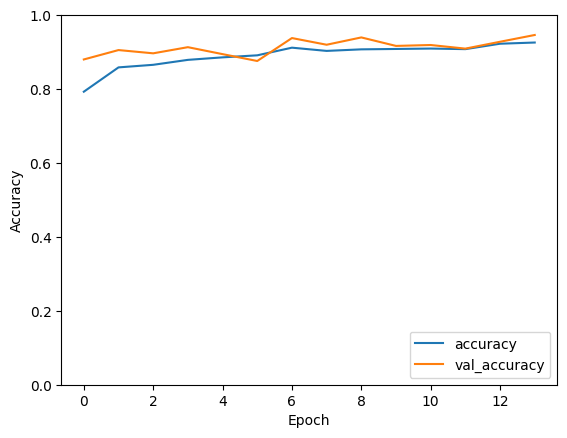

In [11]:
# Plot the training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [12]:
# plot the confusion matrix for the quantized model
from sklearn.metrics import confusion_matrix
import itertools

"""
function: plot_confusion_matrix
    - input: cm, classes, normalize, title, cmap
    - output: none
    - description: plots the confusion matrix
"""

def plot_confusion_matrix(cm, classes,
                            normalize=False,
                            title='Confusion matrix',
                            cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

7/7 [==============================] - 0s 5ms/step
[[88 10]
 [12 92]]
Confusion matrix, without normalization
[[88 10]
 [12 92]]


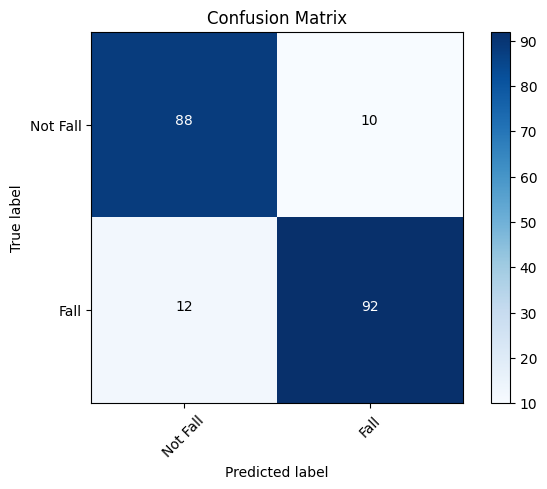

In [13]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Convert y_test back to its original form
y_test_original = np.argmax(y_test, axis=-1)

# Get the model's predictions
predictions = np.argmax(ConvLSTM.predict(X_test), axis=-1)

# Compute the confusion matrix
cm = confusion_matrix(y_test_original, predictions)

print(cm)
# plot the confusion matrix
plot_confusion_matrix(cm, classes=['Not Fall', 'Fall'], normalize=False, title='Confusion Matrix')

In [14]:
ConvLSTM.save('ConvLSTM.keras')  # The file needs to end with the .keras extension


In [15]:
# quantize_scope = tfmot.quantization.keras.quantize_scope
# with quantize_scope(
#   {'DefaultLSTMQuantizeConfig': DefaultLSTMQuantizeConfig,
#    'CustomLSTM': CustomLSTM}):
#   # Use `quantize_apply` to actually make the model quantization aware.
#   q_ConvLSTM = tfmot.quantization.keras.quantize_model(ConvLSTM)
  
# q_ConvLSTM = tfmot.quantization.keras.quantize_model(ConvLSTM)
# q_ConvLSTM.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
#                 loss='categorical_crossentropy',
#                 #loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#                 metrics=['accuracy'])

# q_ConvLSTM.summary()


In [ ]:
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
# lrs = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=patience, verbose=1)
# print('X_train.shape: ', X_train.shape) # (23291, 50, 9)
# print('y_train.shape: ', y_train.shape) # (23291,)

# history = ConvLSTM.fit(X_train, y_train, 
#           validation_data=(X_val, y_val), 
#           epochs=epochs, 
#           batch_size=batch_size,
#           callbacks=[es, lrs],
#           class_weight=class_weight) 